In [1]:
import tensorflow as tf

# Transfer learning: Feature Extraction

Transfer learning is taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

1. Can leverage an exis
oven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

## Download and checkout the data

In [2]:
# Get data (10% of food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# Unzip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2025-03-30 18:31:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 142.251.188.207, 192.178.163.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  78.1MB/s    in 2.1s    

2025-03-30 18:31:25 (78.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
#How many images?
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 10 directori

## Creating data loaders (preparing the data)
Use `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Setup the data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

train_data = train_data_gen.flow_from_directory(train_dir,
                                                target_size=IMG_SHAPE,
                                                batch_size=BATCH_SIZE,
                                                class_mode="categorical")

test_data = test_data_gen.flow_from_directory(test_dir,
                                                target_size=IMG_SHAPE,
                                                batch_size=BATCH_SIZE,
                                                class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

In fact, we're going to use two models from TensorFlow Hub:

- ResNetV2 - a state of the art computer vision model architecture from 2016.
- EfficientNet - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on ImageNet (ILSVRC-2012-CLS), the gold standard of computer vision benchmarks.


In [6]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras
from tf_keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [8]:
# Make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor = hub.KerasLayer(model_url,
                                     trainable=False,
                                     name="feature_extraction_layer",
                                     input_shape=IMG_SHAPE+(3,))
  # Create our own model
  model = keras.Sequential([
      feature_extractor,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Featur Extraction


In [9]:
# Create a Resnet model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

In [10]:
# Compile
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [12]:
# Fit the model to the data
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")],
                                  validation_steps=len(test_data)
                                  )

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250330-183142
Epoch 1/5
24/24 [==============================] - 38s 828ms/step - loss: 1.9711 - accuracy: 0.3360 - val_loss: 1.1898 - val_accuracy: 0.6304
Epoch 2/5
24/24 [==============================] - 11s 465ms/step - loss: 0.9302 - accuracy: 0.7227 - val_loss: 0.8605 - val_accuracy: 0.7220
Epoch 3/5
24/24 [==============================] - 10s 441ms/step - loss: 0.6361 - accuracy: 0.8227 - val_loss: 0.7600 - val_accuracy: 0.7472
Epoch 4/5
24/24 [==============================] - 12s 532ms/step - loss: 0.4822 - accuracy: 0.8680 - val_loss: 0.6986 - val_accuracy: 0.7684
Epoch 5/5
24/24 [==============================] - 11s 476ms/step - loss: 0.3894 - accuracy: 0.9133 - val_loss: 0.6928 - val_accuracy: 0.7684


In [30]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [13]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


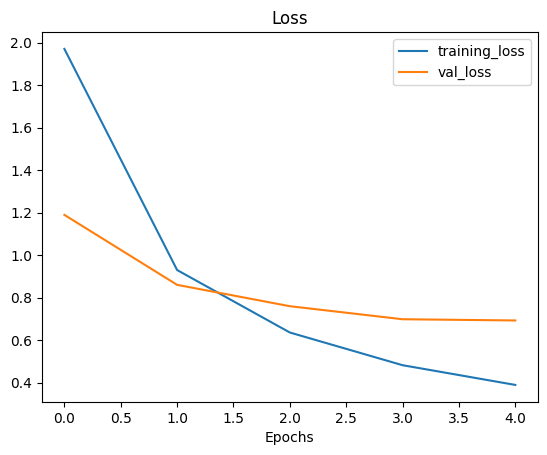

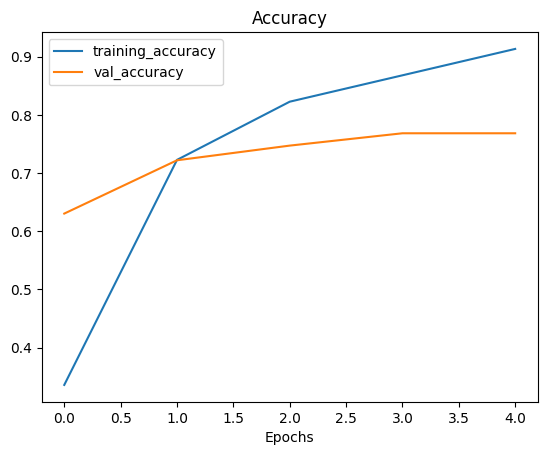

In [14]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Featur Extraction

In [15]:
# Create EfficientNetB0 model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data.num_classes)
# Compile
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer="Adam",
                           metrics=["accuracy"])
# Fit
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                    experiment_name="efficientnetb0"))

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20250330-184343
Epoch 1/5
24/24 [==============================] - 28s 630ms/step - loss: 1.8367 - accuracy: 0.4640 - val_loss: 1.2798 - val_accuracy: 0.7344
Epoch 2/5
24/24 [==============================] - 10s 435ms/step - loss: 1.0466 - accuracy: 0.7600 - val_loss: 0.8642 - val_accuracy: 0.8212
Epoch 3/5
24/24 [==============================] - 12s 522ms/step - loss: 0.7623 - accuracy: 0.8440 - val_loss: 0.6969 - val_accuracy: 0.8404
Epoch 4/5
24/24 [==============================] - 9s 400ms/step - loss: 0.5941 - accuracy: 0.8627 - val_loss: 0.5954 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 10s 445ms/step - loss: 0.5164 - accuracy: 0.8827 - val_loss: 0.5559 - val_accuracy: 0.8632


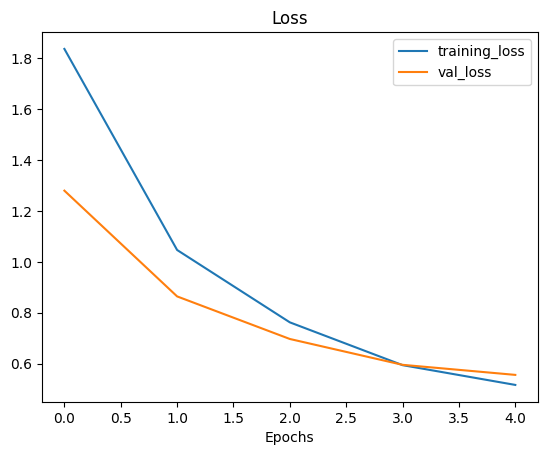

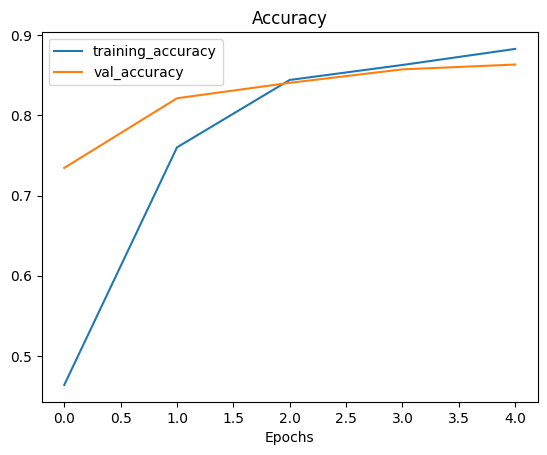

In [16]:
plot_loss_curves(efficientnet_history)

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


### Different types of transfer learning
- "As is" transfer learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
- "Feature extraction" transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
- "Fine-tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [22]:
#efficientnet_model.layers[0].weights

## Comparing our models using TensorBoard

In [23]:
# # Upload TensorBoard dev records
# !tensorboard dev upload --log_dir ./tensorflow_hub/ \
#   --name "ResNet50V2 vs EfficientNetB0" \
#   --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
#   --one_shot

In [25]:
# Check out experiments
# !tensorboard dev list

In [26]:
# # Delete an experiment
# !tensorboard dev delete --experiment_id id_val

In [27]:
# Check to see if experiments still exist
# !tensorboard dev list # uncomment to see